# Force Optimizations Data Analysis 

In [11]:
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from paretoset import paretoset

## Data Analaysis
Let's go ahead and analyze our data from the `output` folder! We'll begin by importing the `.json` files and creating a `DataFrame` of the results.

In [12]:
# Initialize an empty DataFrame
df = pd.DataFrame()

results = glob.glob("./output/initial/*/results.json")
for results_file in results:
    with open(results_file, "r") as f:
        data = json.load(f)

    # Wrap lists in another list
    for key, value in data.items():
        if isinstance(value, list):
            data[key] = [value]

    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

We can now filter out the data according to some pre-specified criteria.

In [13]:
margin_up   = 1.05
margin_low  = 0.95
allowed_length  = 5.00 * margin_up
allowed_κ       = 12.00 * margin_up
allowed_MSC     = 6.00 * margin_up
allowed_CC_dist = 0.083 * margin_low
allowed_CS_dist = 0.166 * margin_low
allowed_arclen_var = 1e-2
# allowed_CS_dist_max = 0.375

succeeded = df["linking_number"] < 0.1
succeeded = np.logical_and(succeeded, df["max_length"] < allowed_length)
succeeded = np.logical_and(succeeded, df["max_max_κ"] < allowed_κ)
succeeded = np.logical_and(succeeded, df["max_MSC"] < allowed_MSC)
succeeded = np.logical_and(succeeded, df["coil_coil_distance"] > allowed_CC_dist)
succeeded = np.logical_and(succeeded, df["coil_surface_distance"] > allowed_CS_dist)
succeeded = np.logical_and(succeeded, df["max_arclength_variance"] < allowed_arclen_var)
# succeeded = np.logical_and(succeeded, df["coil_surface_distance"] < allowed_CS_dist_max)

df_filtered = df[succeeded]

We can easily create the Paredo front of our results.

In [14]:
pareto_mask = paretoset(df_filtered[["normalized_BdotN", "max_max_force"]], sense=[min, min])
df_pareto = df_filtered[pareto_mask]

If desired, we can create a nice table summarizing the results as well. 

In [15]:
print("Best Pareto-optimal results:")
print(
    (df_pareto[
        [
            "UUID",
            "BdotN",
            "max_max_force",
            "max_max_κ",
            "max_MSC",
            "max_length",
            "coil_coil_distance",
            "coil_surface_distance"
        ]
    ]).to_markdown()
)

Best Pareto-optimal results:
|     | UUID                             |       BdotN |   max_max_force |   max_max_κ |   max_MSC |   max_length |   coil_coil_distance |   coil_surface_distance |
|----:|:---------------------------------|------------:|----------------:|------------:|----------:|-------------:|---------------------:|------------------------:|
|  26 | be1f000369234fd29a08c971d303948f | 0.000169638 |        23718.8  |     4.72366 |   5.95131 |      4.93472 |            0.141205  |                0.249435 |
|  39 | 9bce7ea478e148c196165869492772d6 | 0.000326231 |        17819.9  |     4.64567 |   5.18988 |      4.85289 |            0.163615  |                0.22034  |
|  50 | 37bb15be5a914d6482fe2e687bca9373 | 0.00081547  |         6004.25 |     4.48111 |   5.79504 |      4.81978 |            0.0984733 |                0.284746 |
|  78 | deb0701a1b0b4b21853957738a7114bd | 0.000109369 |        39355.4  |     4.30164 |   4.41005 |      4.97868 |            0.109776  |        

# Plotting
## Paredo Fronts
Time to get plotting! We can begin by generating the Paredo fronts with color scales representing additional parameters such as maximum coil length and the Fourier order of the coils. 

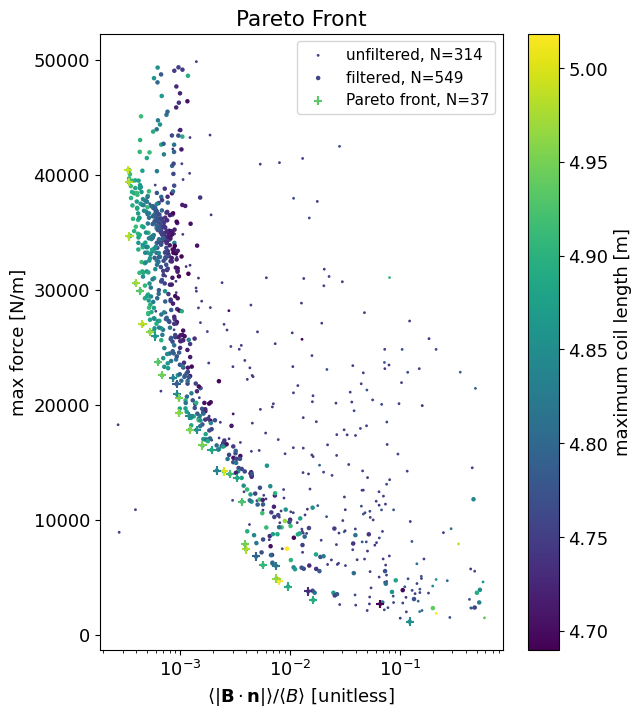

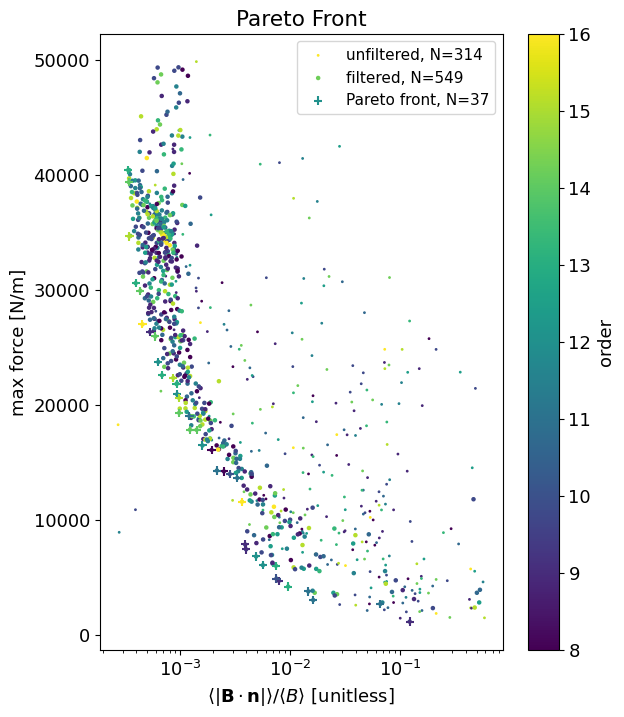

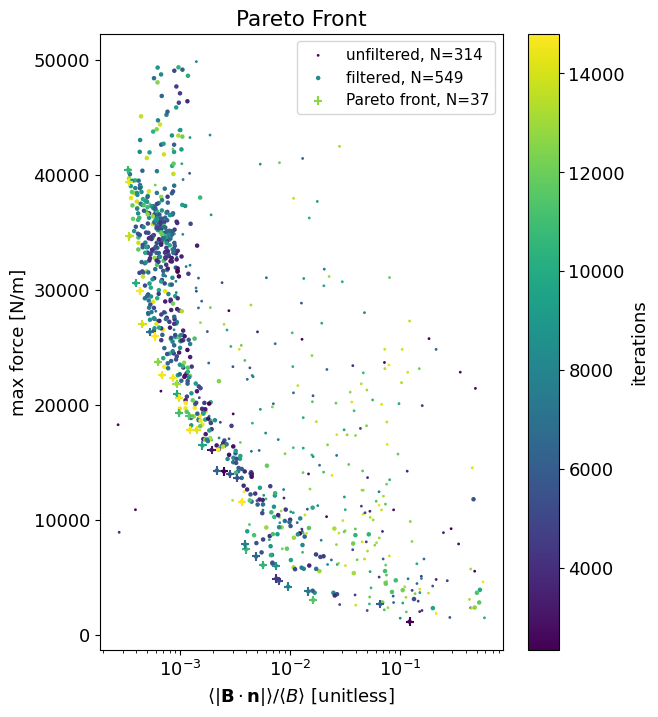

In [19]:
markersize = 5
n_pareto = df_pareto.shape[0]
n_filtered = df_filtered.shape[0] - n_pareto
n_unfiltered = df.shape[0] - n_filtered

plt.figure(figsize=(6.5, 8))
plt.rc("font", size=13)
plt.scatter(
    df["normalized_BdotN"], 
    df["max_max_force"], 
    c=df["max_length"], 
    s=1, 
    label=f'unfiltered, N={n_unfiltered}')
plt.scatter(
    df_filtered["normalized_BdotN"],
    df_filtered["max_max_force"],
    c=df_filtered["max_length"],
    s=markersize,
    label=f'filtered, N={n_filtered}'
)
plt.scatter(
    df_pareto["normalized_BdotN"], 
    df_pareto["max_max_force"], 
    c=df_pareto["max_length"], 
    marker="+",
    label=f'Pareto front, N={n_pareto}'
)
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xscale("log")
plt.colorbar(label="maximum coil length [m]")
plt.legend(loc='upper right', fontsize='11')
plt.title('Pareto Front')
plt.show()

for color in ['order', 'iterations, ncoils']:
    plt.figure(figsize=(6.5, 8))
    plt.rc("font", size=13)
    plt.scatter(
        df["normalized_BdotN"], 
        df["max_max_force"], 
        c=df[color], 
        s=1, 
        label=f'unfiltered, N={n_unfiltered}')
    plt.scatter(
        df_filtered["normalized_BdotN"],
        df_filtered["max_max_force"],
        c=df_filtered[color],
        s=markersize,
        label=f'filtered, N={n_filtered}'
    )
    plt.scatter(
        df_pareto["normalized_BdotN"], 
        df_pareto["max_max_force"], 
        c=df_pareto[color], 
        marker="+",
        label=f'Pareto front, N={n_pareto}'
    )
    plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
    plt.ylabel("max force [N/m]")
    plt.xscale("log")
    plt.colorbar(label=color)
    plt.legend(loc='upper right', fontsize='11')
    plt.title('Pareto Front')
    plt.show()

We can also make these plots interactive by using Plotly.

In [20]:
import plotly.express as px
for color in ['max_length']:
    fig = px.scatter(
        df_pareto, 
        x="normalized_BdotN", 
        y="max_max_force", 
        color=color,
        log_x=True,
        width=600, 
        height=400,
        title="Initial Force Optimizations Pareto Front",
        hover_data={
            'UUID':True,
            'max_max_force':':.2e',
            'coil_surface_distance':':.2e'
            }
        )

    fig.update_layout(
        margin=dict(l=20, r=20, t=40, b=20),
        plot_bgcolor='white'
    )

    fig.update_xaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        tickformat='.1e',
        dtick=0.25
    )
    fig.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        tickformat = "000"
    )


    fig.show()

fig = px.scatter(
        df, 
        x="normalized_BdotN", 
        y="max_max_force", 
        color=color,
        log_x=True,
        width=600, 
        height=400,
        title="Initial Force Optimizations",
        hover_data={
            'UUID':True,
            'max_max_force':':.2e',
            'coil_surface_distance':':.2e'
            }
        )
fig.show()

## Parameter Success
Now, let's analyze the success of various parameters.

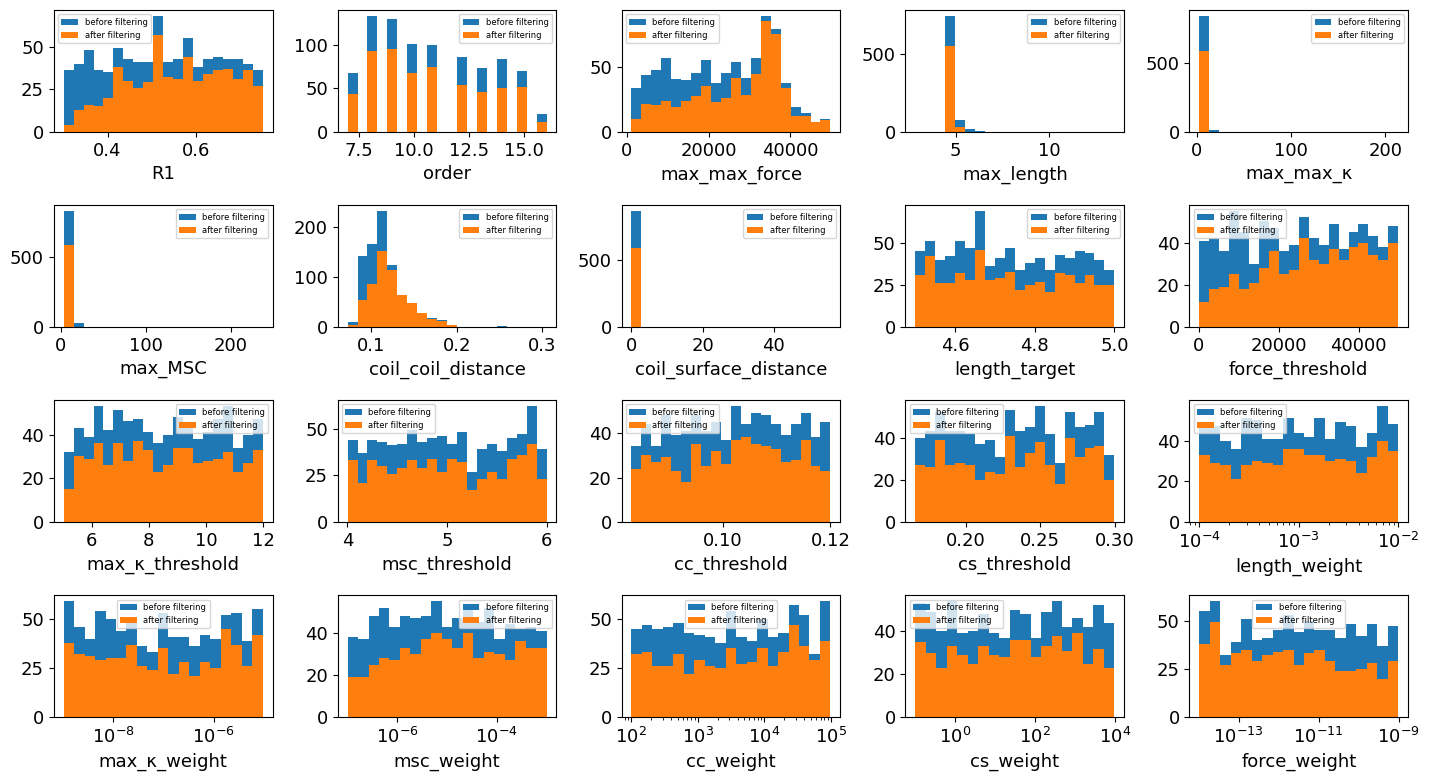

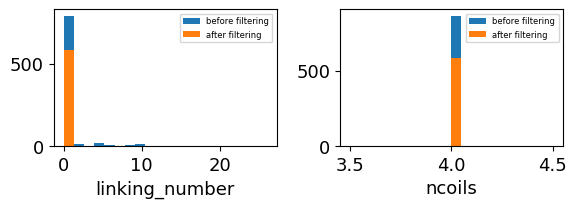

In [24]:
plt.figure(1, figsize=(14.5, 8))
nrows = 4
ncols = 5

subplot_index = 1
def plot_2d_hist(field, log=False):
    global subplot_index
    plt.subplot(nrows, ncols, subplot_index)
    subplot_index += 1
    nbins = 20
    if log:
        data = df[field]
        bins = np.logspace(np.log10(data.min()), np.log10(data.max()), nbins)
    else:
        bins = nbins
    n,bins,patchs = plt.hist(df[field], bins=bins, label="before filtering")
    plt.hist(df_filtered[field], bins=bins, alpha=1, label="after filtering")
    plt.xlabel(field)
    plt.legend(loc=0, fontsize=6)
    if log:
        plt.xscale("log")


# 2nd entry of each tuple is True if the field should be plotted on a log x-scale.
fields = (
    ("R1", False),
    ("order", False),
    ("max_max_force", False),
    ("max_length", False),
    ("max_max_κ", False),
    ("max_MSC", False),
    ("coil_coil_distance", False),
    ("coil_surface_distance", False),
    ("length_target", False),
    ("force_threshold", False),
    ("max_κ_threshold", False),
    ("msc_threshold", False),
    ("cc_threshold", False),
    ("cs_threshold", False),
    ("length_weight", True),
    ("max_κ_weight", True),
    ("msc_weight", True),
    ("cc_weight", True),
    ("cs_weight", True),
    ("force_weight", True),
)

for field, log in fields:
    plot_2d_hist(field, log)

plt.tight_layout()
plt.show()
subplot_index = 1

plt.figure(figsize=(14.5, 8))
# 2nd entry of each tuple is True if the field should be plotted on a log x-scale.
fields = (
    ("linking_number", False),
    ('ncoils', False)
)

for field, log in fields:
    plot_2d_hist(field, log)

plt.tight_layout()
plt.show()